# Uniswap V2
For this strategy, we will provide the liquidity just as in Uniswap v2. We will provide liquidity in the interval [minTick, maxTick].

Import code dependencies

In [2]:
from datetime import date, datetime
import pandas as pd

from demeter import TokenInfo, Actuator, Strategy,  ChainType, MarketInfo, AtTimeTrigger
from demeter.result import performance_metrics, round_results
from demeter.uniswap import UniV3Pool, UniLpMarket
from demeter import Snapshot


Set pandas output format

In [3]:
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

Custom Uniswap V2 strategy with add liquidity from tick -887272(minTick) to 887272(maxTick)

In [6]:
class UniswapV2Strategy(Strategy):
    def initialize(self):
        """
        Initialize function will be called right before a backtest start.
        You can do various things here, e.g. register a trigger, or add a simple moving average line.
        """
        new_trigger = AtTimeTrigger(  
            time=datetime(2025, 1, 1, 0, 0, 0), do=self.work
        ) 
        self.triggers.append(new_trigger)  

    def work(self, row_data: Snapshot):
        """
        When time is up, work function will be called.
        """
        lp_market: UniLpMarket = self.markets[market_key] 
        lp_market.add_liquidity_by_tick(-887272, 887272) 
        pass

Main logic to run Actuator, init two token and market with key "market1"

In [7]:

# Declare tokens with names to be used as units for amounts
usdc = TokenInfo(name="usdc", decimal=6)
eth = TokenInfo(name="eth", decimal=18)

# Initialize Uniswap V3 Pool with parameters matching the on-chain pool
pool = UniV3Pool(token0=usdc, token1=eth, fee=0.05, quote_token=usdc)

# Define market key and create the Uniswap V3 market
market_key = MarketInfo("market1")
market = UniLpMarket(market_key, pool)

# Load market data
market.data_path = "../data"
market.load_data(
    chain="ethereum",
    contract_addr="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
    start_date=date(2025, 1, 1),
    end_date=date(2025, 3, 1)
)

# Initialize Actuator and configure the broker
actuator = Actuator()
actuator.broker.add_market(market)
actuator.broker.set_balance(usdc, 5000)
actuator.broker.set_balance(eth, 1)

# Set strategy and assign price data from the Uniswap pool
actuator.strategy = UniswapV2Strategy()
actuator.set_price(market.get_price_from_data())

# Run the test and display performance metrics
actuator.run()
print(round_results(performance_metrics(actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"])))

# Save results to the specified path
actuator.save_result(
    path="./result",
    account=True,
    actions=True
)

2025-03-11 07:36:35,689 - INFO - Uni data - Load data from cache
2025-03-11 07:36:35,819 - INFO - Actuator - Quote token is USDC
2025-03-11 07:36:35,820 - INFO - Actuator - init strategy...
2025-03-11 07:36:35,822 - INFO - Actuator - start main loop...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400/86400 [00:44<00:00, 1957.39it/s]
2025-03-11 07:37:19,967 - INFO - Actuator - main loop finished
2025-03-11 07:37:21,873 - INFO - Actuator - Print actuator summary


Final account status                              
Token balance in broker       
USDC      :1668.1030                ETH       :0                        
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0     pending1       liquidity
0     -887270      887270  41.547319  0.014615225  57722586434959

Quote by: USDC
Account balance history                           


2025-03-11 07:37:22,378 - INFO - Actuator - Backtest with process id: 1771693 finished, execute time 46.562s


l1                  net_value   tokens       market1                                                                                                          price     
l2                                USDC ETH net_value liquidity_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2025-01-01 00:00:00 8331.8973 1668.103   0 6663.7943        6663.794    9.0443364e-08     1.1776507e-05                1          3331.897              1  3331.897    1
2025-01-01 00:01:00 8331.5643 1668.103   0 6663.4612       6663.4608    9.8442556e-08     0.00011231578          1.00005         3331.7304              1 3331.5638    1
2025-01-01 00:02:00 8331.8978 1668.103   0 6663.7948        6663.794    1.0000778e-07     0.00050333218                1          3331.897              1  3331.897    1
2025-01-01 00:03:00 8333.5639 1668.103   0 6665.4609         6665.46    1.0188849e-07     0.00050333218       0.99975004           3332.73              1 3

2025-03-11 07:37:23,823 - INFO - Actuator - files have saved to ./result/backtest-20250311-073722.pkl,./result/backtest-20250311-073722.account.csv


['./result/backtest-20250311-073722.pkl',
 './result/backtest-20250311-073722.account.csv']

Run actuator with evaluators and save result to files

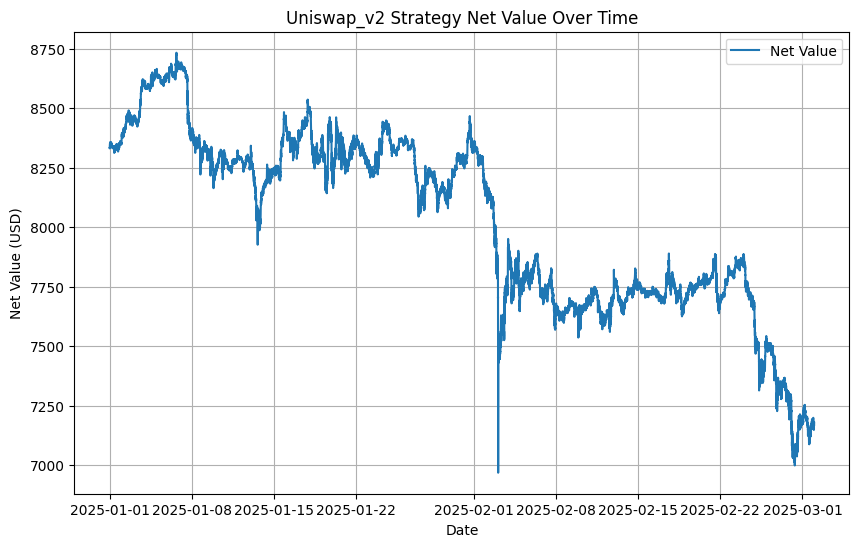

In [8]:
import matplotlib.pyplot as plt

# Plot the net_value of the strategy over time
plt.figure(figsize=(10, 6))
plt.plot(actuator.account_status_df.index, actuator.account_status_df["net_value"], label="Net Value")
plt.xlabel("Date")
plt.ylabel("Net Value (USD)")
plt.title("Uniswap_v2 Strategy Net Value Over Time")
plt.legend()
plt.grid(True)
plt.show()
